In [21]:
import os
import hashlib
import requests
import zipfile, tarfile
import numpy as np
from collections import defaultdict

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

def download():
    url, sha1_hash = ('http://d2l-data.s3-accelerate.amazonaws.com/ctr.zip',
                        'e18327c48c8e8e5c23da714dd614e390d369843f')
    cache_dir=os.path.join('..', 'data')
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(folder=None):
    fname = download()
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir


In [22]:
class CTRDataset(Dataset):
    def __init__(self, data_path, feat_mapper=None, defaults=None,
                 min_threshold=4, num_feat=34):
        self.NUM_FEATS, self.count, self.data = num_feat, 0, {}
        feat_cnts = defaultdict(lambda: defaultdict(int))
        self.feat_mapper, self.defaults = feat_mapper, defaults
        self.field_dims = np.zeros(self.NUM_FEATS, dtype=np.int64)
        with open(data_path) as f:
            for line in f:
                instance = {}
                values = line.rstrip('\n').split('\t')
                if len(values) != self.NUM_FEATS + 1:
                    continue
                label = np.float32([0, 0])
                label[int(values[0])] = 1
                instance['y'] = [np.float32(values[0])]
                for i in range(1, self.NUM_FEATS + 1):
                    feat_cnts[i][values[i]] += 1
                    instance.setdefault('x', []).append(values[i])
                self.data[self.count] = instance
                self.count = self.count + 1
        if self.feat_mapper is None and self.defaults is None:
            feat_mapper = {i: {feat for feat, c in cnt.items() if c >=
                               min_threshold} for i, cnt in feat_cnts.items()}
            self.feat_mapper = {i: {feat_v: idx for idx, feat_v in enumerate(feat_values)}
                                for i, feat_values in feat_mapper.items()}
            self.defaults = {i: len(feat_values) for i, feat_values in feat_mapper.items()}
        for i, fm in self.feat_mapper.items():
            self.field_dims[i - 1] = len(fm) + 1
        self.offsets = np.array((0, *np.asarray(np.cumsum(self.field_dims))
                                 [:-1]))

    def __len__(self):
        return self.count

    def __getitem__(self, idx):
        feat = np.array([self.feat_mapper[i + 1].get(v, self.defaults[i + 1])
                         for i, v in enumerate(self.data[idx]['x'])])
        return feat + self.offsets, self.data[idx]['y']

In [13]:
data_dir = download_extract()
NUM_FEATS, count, data = 34, 0, {}
feat_cnts = defaultdict(lambda: defaultdict(int))
feat_mapper, defaults = None, None
field_dims = np.zeros(NUM_FEATS, dtype=np.int64)
with open(os.path.join(data_dir, 'train.csv')) as f:
    for line in f:
        instance = {}
        values = line.rstrip('\n').split('\t')
        if len(values) != NUM_FEATS + 1:
            continue
        label = np.float32([0, 0])
        label[int(values[0])] = 1
        instance['y'] = [np.float32(values[0])]
        for i in range(1, NUM_FEATS + 1):
            feat_cnts[i][values[i]] += 1
            instance.setdefault('x', []).append(values[i])
        data[count] = instance
        count = count + 1

In [14]:
if feat_mapper is None and defaults is None:
    feat_mapper = {i: {feat for feat, c in cnt.items() if c >=
                        4} for i, cnt in feat_cnts.items()}
    feat_mapper = {i: {feat_v: idx for idx, feat_v in enumerate(feat_values)}
                        for i, feat_values in feat_mapper.items()}
    defaults = {i: len(feat_values) for i, feat_values in feat_mapper.items()}
for i, fm in feat_mapper.items():
    field_dims[i - 1] = len(fm) + 1
offsets = np.array((0, *np.asarray(np.cumsum(field_dims))
                          [:-1]))

In [86]:
class FM(nn.Module):
    def __init__(self, field_dims, num_factors):
        super(FM, self).__init__()
        self.embedding = nn.Embedding(field_dims, num_factors)
        self.fc = nn.Embedding(field_dims, 1)
        self.linear_layer = nn.Linear(1,1)

    def forward(self, x):
        square_of_sum = torch.sum(self.embedding(x), axis=1) ** 2
        sum_of_square = torch.sum(self.embedding(x) ** 2, axis=1)
        x = self.linear_layer(self.fc(x).sum(1)) \
            + 0.5 * (square_of_sum - sum_of_square).sum(1, keepdims=True)
        x = torch.sigmoid(x)
        return x

In [88]:
batch_size = 2048
data_dir = download_extract()
train_data = CTRDataset(os.path.join(data_dir, 'train.csv'))
test_data = CTRDataset(os.path.join(data_dir, 'test.csv'),
                           feat_mapper=train_data.feat_mapper,
                           defaults=train_data.defaults)
train_iter = DataLoader(train_data, shuffle=True, batch_size = batch_size)
test_iter = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [89]:
train_data = CTRDataset(os.path.join(data_dir, 'train.csv'))
train_data[0]

(array([ 143,  146,  227,  251,  957, 1250, 1471, 1566, 1624, 1718, 2008,
        2061, 2175, 2304, 2305, 2360, 2745, 2746, 2747, 2748, 2892, 2988,
        3165, 3171, 3194, 3195, 3341, 3653, 3687, 3701, 3727, 3750, 3789,
        3813]), [1.0])

In [90]:
next(iter(train_iter))

[tensor([[ 143,  145,  227,  ..., 3741, 3789, 3803],
         [ 143,  144,  227,  ..., 3755, 3775, 3804],
         [ 143,  146,  227,  ..., 3742, 3781, 3811],
         ...,
         [ 143,  144,  227,  ..., 3750, 3772, 3791],
         [ 143,  145,  227,  ..., 3746, 3778, 3801],
         [ 143,  146,  227,  ..., 3759, 3769, 3793]]),
 [tensor([0., 1., 0.,  ..., 1., 1., 1.])]]

In [92]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = FM(int(sum(train_data.field_dims)), num_factors=20)
net.to(device)
lr, num_epochs, wd = 0.002, 50, 1e-5
loss_func = torch.nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = lr, weight_decay=wd)

In [118]:
from tqdm import tqdm
import glob

train_epoch_loss = []
val_epoch_loss_lst = []
best_val_epoch_loss = int(1e9)
for epoch in tqdm(range(num_epochs)):
  train_iter_loss = []
  for i, values in enumerate(train_iter):
    train_data = values[0].long().to(device)
    labels = values[1][0].long().to(device).unsqueeze(1) 
    preds = net(train_data) #.squeeze()
    loss = loss_func(preds.to(torch.float32), labels.to(torch.float32))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_iter_loss.append(loss.detach().item())
    if i%50 == 0:
      print(f'{epoch} epoch {i}th train iter loss: {loss.detach().item()}')  
  train_epoch_loss.append(np.mean(train_iter_loss))
  print(f'{epoch} epoch ALL LOSS : ', np.mean(train_iter_loss))
  
  with torch.no_grad():
    net.eval()
    val_epoch_loss = 0
    for i, values in enumerate(test_iter):
      test_data = values[0].long().to(device)
      labels = values[1][0].long().to(device).unsqueeze(1) 
      preds = net(test_data)
      loss = loss_func(preds.to(torch.float32), labels.to(torch.float32))
      val_epoch_loss += loss.detach().item()
  val_epoch_loss /= len(test_iter)
  val_epoch_loss_lst.append(val_epoch_loss)

  if val_epoch_loss < best_val_epoch_loss:
    best_val_epoch_loss = val_epoch_loss
    print(f'New best model loss: {best_val_epoch_loss}')
    if not os.path.exists('model'):
      os.mkdir('model')

    if os.path.exists('model/best.pth'):
      os.remove('model/best.pth')
    torch.save(net.state_dict(), 'model/best.pth')
    print('best model is saved!')
    
  

  0%|          | 0/50 [00:00<?, ?it/s]

0 epoch 0th train iter loss: 44.79462432861328


  2%|▏         | 1/50 [00:00<00:29,  1.68it/s]

0 epoch ALL LOSS :  42.39602088928223
New best model loss: 42.577980041503906
best model is saved!
1 epoch 0th train iter loss: 44.41352844238281


  4%|▍         | 2/50 [00:01<00:26,  1.81it/s]

1 epoch ALL LOSS :  41.80970621109009
New best model loss: 41.801340103149414
best model is saved!
2 epoch 0th train iter loss: 41.643775939941406


  6%|▌         | 3/50 [00:01<00:25,  1.86it/s]

2 epoch ALL LOSS :  41.06938171386719
New best model loss: 41.09583854675293
best model is saved!
3 epoch 0th train iter loss: 39.95976257324219


  8%|▊         | 4/50 [00:02<00:27,  1.67it/s]

3 epoch ALL LOSS :  40.396461486816406
New best model loss: 40.70281791687012
best model is saved!
4 epoch 0th train iter loss: 40.92932891845703


 10%|█         | 5/50 [00:02<00:25,  1.74it/s]

4 epoch ALL LOSS :  39.994619369506836
New best model loss: 40.382755279541016
best model is saved!
5 epoch 0th train iter loss: 38.03245162963867


 12%|█▏        | 6/50 [00:03<00:25,  1.75it/s]

5 epoch ALL LOSS :  39.5052752494812
New best model loss: 39.46396446228027
best model is saved!
6 epoch 0th train iter loss: 40.37263488769531


 14%|█▍        | 7/50 [00:04<00:26,  1.65it/s]

6 epoch ALL LOSS :  38.75809383392334
New best model loss: 38.99028205871582
best model is saved!
7 epoch 0th train iter loss: 37.91037368774414


 16%|█▌        | 8/50 [00:04<00:25,  1.68it/s]

7 epoch ALL LOSS :  38.078269958496094
New best model loss: 38.67011642456055
best model is saved!
8 epoch 0th train iter loss: 36.50517272949219


 18%|█▊        | 9/50 [00:05<00:23,  1.72it/s]

8 epoch ALL LOSS :  37.857736110687256
New best model loss: 37.890037536621094
best model is saved!
9 epoch 0th train iter loss: 38.351539611816406


 20%|██        | 10/50 [00:05<00:24,  1.63it/s]

9 epoch ALL LOSS :  36.575345039367676
New best model loss: 36.758195877075195
best model is saved!
10 epoch 0th train iter loss: 37.3544921875


 22%|██▏       | 11/50 [00:06<00:22,  1.71it/s]

10 epoch ALL LOSS :  36.01102304458618
New best model loss: 36.07355308532715
best model is saved!
11 epoch 0th train iter loss: 36.1242561340332


 24%|██▍       | 12/50 [00:06<00:21,  1.74it/s]

11 epoch ALL LOSS :  35.48285722732544
New best model loss: 35.29950714111328
best model is saved!
12 epoch 0th train iter loss: 34.542198181152344


 26%|██▌       | 13/50 [00:07<00:22,  1.66it/s]

12 epoch ALL LOSS :  34.86669206619263
New best model loss: 34.23959541320801
best model is saved!
13 epoch 0th train iter loss: 33.605812072753906


 28%|██▊       | 14/50 [00:08<00:20,  1.72it/s]

13 epoch ALL LOSS :  33.52605676651001
New best model loss: 33.12469005584717
best model is saved!
14 epoch 0th train iter loss: 33.01433181762695


 30%|███       | 15/50 [00:08<00:19,  1.77it/s]

14 epoch ALL LOSS :  31.377765655517578
New best model loss: 31.75142478942871
best model is saved!
15 epoch 0th train iter loss: 31.984806060791016
15 epoch ALL LOSS :  30.21878933906555


 32%|███▏      | 16/50 [00:09<00:20,  1.66it/s]

New best model loss: 30.382533073425293
best model is saved!
16 epoch 0th train iter loss: 29.08308982849121


 34%|███▍      | 17/50 [00:09<00:19,  1.71it/s]

16 epoch ALL LOSS :  28.120681524276733
New best model loss: 28.760611534118652
best model is saved!
17 epoch 0th train iter loss: 26.4034481048584


 36%|███▌      | 18/50 [00:10<00:18,  1.74it/s]

17 epoch ALL LOSS :  26.971077919006348
New best model loss: 27.78393840789795
best model is saved!
18 epoch 0th train iter loss: 25.895977020263672


 38%|███▊      | 19/50 [00:11<00:17,  1.77it/s]

18 epoch ALL LOSS :  25.52137851715088
New best model loss: 25.66211223602295
best model is saved!
19 epoch 0th train iter loss: 23.479385375976562


 40%|████      | 20/50 [00:11<00:18,  1.66it/s]

19 epoch ALL LOSS :  22.991846084594727
New best model loss: 23.940078735351562
best model is saved!
20 epoch 0th train iter loss: 23.303741455078125


 42%|████▏     | 21/50 [00:12<00:16,  1.73it/s]

20 epoch ALL LOSS :  22.204509735107422
New best model loss: 22.79116439819336
best model is saved!
21 epoch 0th train iter loss: 21.729537963867188


 44%|████▍     | 22/50 [00:12<00:15,  1.76it/s]

21 epoch ALL LOSS :  20.340126037597656
New best model loss: 21.038533210754395
best model is saved!
22 epoch 0th train iter loss: 18.722034454345703


 46%|████▌     | 23/50 [00:13<00:16,  1.67it/s]

22 epoch ALL LOSS :  19.17989754676819
New best model loss: 20.438227653503418
best model is saved!
23 epoch 0th train iter loss: 19.378067016601562


 48%|████▊     | 24/50 [00:14<00:15,  1.72it/s]

23 epoch ALL LOSS :  18.300710916519165
New best model loss: 19.699106216430664
best model is saved!
24 epoch 0th train iter loss: 17.079784393310547


 50%|█████     | 25/50 [00:14<00:14,  1.75it/s]

24 epoch ALL LOSS :  17.159916162490845
New best model loss: 19.011962890625
best model is saved!
25 epoch 0th train iter loss: 17.32464027404785


 52%|█████▏    | 26/50 [00:15<00:14,  1.67it/s]

25 epoch ALL LOSS :  16.11722695827484
New best model loss: 18.441099166870117
best model is saved!
26 epoch 0th train iter loss: 15.484460830688477


 54%|█████▍    | 27/50 [00:15<00:13,  1.68it/s]

26 epoch ALL LOSS :  15.724048018455505
New best model loss: 17.348758697509766
best model is saved!
27 epoch 0th train iter loss: 15.240106582641602


 56%|█████▌    | 28/50 [00:16<00:12,  1.73it/s]

27 epoch ALL LOSS :  14.43210256099701
New best model loss: 16.203733444213867
best model is saved!
28 epoch 0th train iter loss: 14.35411548614502


 58%|█████▊    | 29/50 [00:16<00:11,  1.75it/s]

28 epoch ALL LOSS :  13.98884904384613
New best model loss: 15.596159934997559
best model is saved!
29 epoch 0th train iter loss: 12.47081184387207


 60%|██████    | 30/50 [00:17<00:12,  1.66it/s]

29 epoch ALL LOSS :  13.33377754688263
New best model loss: 14.912091255187988
best model is saved!
30 epoch 0th train iter loss: 12.823114395141602


 62%|██████▏   | 31/50 [00:18<00:11,  1.71it/s]

30 epoch ALL LOSS :  12.786449790000916
New best model loss: 14.29088830947876
best model is saved!
31 epoch 0th train iter loss: 12.75185775756836


 64%|██████▍   | 32/50 [00:18<00:10,  1.73it/s]

31 epoch ALL LOSS :  12.268379092216492
New best model loss: 13.821497440338135
best model is saved!
32 epoch 0th train iter loss: 11.780191421508789


 66%|██████▌   | 33/50 [00:19<00:10,  1.64it/s]

32 epoch ALL LOSS :  11.95231819152832
New best model loss: 13.31905221939087
best model is saved!
33 epoch 0th train iter loss: 11.222881317138672


 68%|██████▊   | 34/50 [00:19<00:09,  1.67it/s]

33 epoch ALL LOSS :  11.45177972316742
New best model loss: 12.99970006942749
best model is saved!
34 epoch 0th train iter loss: 11.265902519226074


 70%|███████   | 35/50 [00:20<00:08,  1.69it/s]

34 epoch ALL LOSS :  10.974640846252441
New best model loss: 12.499038696289062
best model is saved!
35 epoch 0th train iter loss: 10.943953514099121


 72%|███████▏  | 36/50 [00:21<00:08,  1.74it/s]

35 epoch ALL LOSS :  10.64892327785492
New best model loss: 12.29512882232666
best model is saved!
36 epoch 0th train iter loss: 9.46177864074707


 74%|███████▍  | 37/50 [00:21<00:07,  1.65it/s]

36 epoch ALL LOSS :  10.419211983680725
New best model loss: 12.102815628051758
best model is saved!
37 epoch 0th train iter loss: 10.942026138305664


 76%|███████▌  | 38/50 [00:22<00:06,  1.73it/s]

37 epoch ALL LOSS :  10.117240905761719
New best model loss: 11.781439781188965
best model is saved!
38 epoch 0th train iter loss: 11.578184127807617


 78%|███████▊  | 39/50 [00:22<00:06,  1.75it/s]

38 epoch ALL LOSS :  9.937162280082703
New best model loss: 11.69295358657837
best model is saved!
39 epoch 0th train iter loss: 9.199888229370117


 80%|████████  | 40/50 [00:23<00:05,  1.79it/s]

39 epoch ALL LOSS :  9.865083813667297
New best model loss: 11.29677438735962
best model is saved!
40 epoch 0th train iter loss: 9.671597480773926


 82%|████████▏ | 41/50 [00:24<00:05,  1.67it/s]

40 epoch ALL LOSS :  9.27464234828949
New best model loss: 10.98551607131958
best model is saved!
41 epoch 0th train iter loss: 10.827749252319336


 84%|████████▍ | 42/50 [00:24<00:04,  1.73it/s]

41 epoch ALL LOSS :  9.26975417137146
New best model loss: 10.71040153503418
best model is saved!
42 epoch 0th train iter loss: 9.28062629699707


 86%|████████▌ | 43/50 [00:25<00:03,  1.77it/s]

42 epoch ALL LOSS :  9.199713230133057
New best model loss: 10.609135627746582
best model is saved!
43 epoch 0th train iter loss: 9.706514358520508


 88%|████████▊ | 44/50 [00:25<00:03,  1.77it/s]

43 epoch ALL LOSS :  8.783652067184448
New best model loss: 10.310147285461426
best model is saved!
44 epoch 0th train iter loss: 8.550518035888672


 90%|█████████ | 45/50 [00:26<00:03,  1.53it/s]

44 epoch ALL LOSS :  8.756975829601288
New best model loss: 9.98978328704834
best model is saved!
45 epoch 0th train iter loss: 7.966090202331543


 92%|█████████▏| 46/50 [00:27<00:02,  1.47it/s]

45 epoch ALL LOSS :  8.47587639093399
New best model loss: 9.92403507232666
best model is saved!
46 epoch 0th train iter loss: 8.277581214904785


 94%|█████████▍| 47/50 [00:27<00:01,  1.57it/s]

46 epoch ALL LOSS :  8.465321898460388
New best model loss: 9.43065595626831
best model is saved!
47 epoch 0th train iter loss: 8.41292953491211
47 epoch ALL LOSS :  8.082360625267029


 96%|█████████▌| 48/50 [00:28<00:01,  1.54it/s]

48 epoch 0th train iter loss: 8.808492660522461


 98%|█████████▊| 49/50 [00:29<00:00,  1.62it/s]

48 epoch ALL LOSS :  8.196509063243866
New best model loss: 9.288550853729248
best model is saved!
49 epoch 0th train iter loss: 6.791086196899414


100%|██████████| 50/50 [00:29<00:00,  1.69it/s]

49 epoch ALL LOSS :  8.005861282348633
New best model loss: 9.277645587921143
best model is saved!


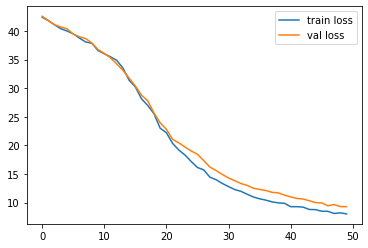

In [119]:
import matplotlib.pyplot as plt

plt.plot(train_epoch_loss, label='train loss')
plt.plot(val_epoch_loss_lst, label='val loss')
plt.legend()